In [117]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [118]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

RANDOM_SEED = 2080
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [119]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
print(df.shape)
df.columns

(73370, 142)


Index(['Unnamed: 0', 'age', 'bmi', 'elective_surgery', 'gender',
       'pre_icu_los_days', 'apache_post_operative', 'arf_apache', 'bun_apache',
       'creatinine_apache',
       ...
       'apache_2_diagnosis_219.0', 'apache_2_diagnosis_301.0',
       'apache_2_diagnosis_302.0', 'apache_2_diagnosis_303.0',
       'apache_2_diagnosis_304.0', 'apache_2_diagnosis_305.0',
       'apache_2_diagnosis_306.0', 'apache_2_diagnosis_307.0',
       'apache_2_diagnosis_308.0', 'hospital_death'],
      dtype='object', length=142)

In [120]:
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

if "Unnamed: 0" in df_test.columns:
    df_test = df_test.drop(columns=["Unnamed: 0"])

X_train = df.drop(columns=["hospital_death"])
y_train = df["hospital_death"].astype(int)
X_test = df_test.drop(columns=["hospital_death"])
y_test = df_test["hospital_death"].astype(int)

In [121]:
def evaluate(name, y_true, y_prob, threshold = .5):
    y_pred = (y_prob >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='binary')
    f1_w = f1_score(y_true, y_pred, average='weighted')

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"AUROC : {auc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall : {rec:.4f}")
    print(f"F1 : {f1:.4f}")
    print(f"F1_weighted : {f1_w:.4f}")
    print("-" * 40)

    return {"model": name, "acc": acc, "auc": auc, "prec": prec, "rec": rec, "f1": f1, "f1_weighted": f1_w}

def plot_metric(results, metric='f1'):
    df = pd.DataFrame(results)
    
    df['run'] = df.groupby('model').cumcount() + 1
    df['label'] = df['model'] + ' #' + df['run'].astype(str)
    
    count = len(df)
    width = max(8, count * 0.4)
    _, ax = plt.subplots(figsize=(width, 6))
    
    ax.bar(df['label'], df[metric])
    ax.set_ylabel(metric.upper() + ' Score')
    ax.set_title(f'{metric.upper()} Score by Model and Run')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

classes = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, cw))
sample_weight_train = np.array([class_weight_dict[y] for y in y_train])

results = []

In [122]:
log_clf = LogisticRegression(max_iter=3000,
                             class_weight=class_weight_dict,
                             penalty = "l2",
                             solver="lbfgs",
                             n_jobs=-1,
                             random_state=RANDOM_SEED)

log_clf.fit(X_train, y_train)
y_prob_lr = log_clf.predict_proba(X_test)[:, 1]
results.append(evaluate("Logistic Regression", y_test, y_prob_lr))

y_pred_logreg = log_clf.predict(X_test)
y_proba = log_clf.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print("Confusion Matrix:")
print(f"TN = {tn}, FP = {fp}")
print(f"FN = {fn}, TP = {tp}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_logreg, digits=4))



=== Logistic Regression ===
Accuracy : 0.8053
AUROC : 0.8706
Precision : 0.2765
Recall : 0.7770
F1 : 0.4078
F1_weighted : 0.8424
----------------------------------------
Confusion Matrix:
TN = 14882, FP = 1878
FN = 540, TP = 1043

Classification Report:
              precision    recall  f1-score   support

           0     0.9746    0.8079    0.8835     16760
           1     0.2765    0.7770    0.4078      1583

    accuracy                         0.8053     18343
   macro avg     0.6255    0.7925    0.6456     18343
weighted avg     0.9143    0.8053    0.8424     18343



In [123]:
param_dist = {
    'n_estimators': [100,200,400,800],
    'learning_rate': [0.01,0.03,0.1],
    'max_depth': [3,5,7],
    'subsample': [0.6,0.8,1.0],
    'colsample_bytree': [0.6,0.8,1.0],
}

xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42)
search_xgb = RandomizedSearchCV(
    xgb, param_distributions=param_dist,
    n_iter=30, cv=4, scoring='roc_auc',
    random_state=2080, n_jobs=-1, verbose=1
)

search_xgb.fit(X_train, y_train, sample_weight=sample_weight_train)
print("Best XGB params:", search_xgb.best_params_)
xgb_clf = search_xgb.best_estimator_


Fitting 4 folds for each of 30 candidates, totalling 120 fits


/opt/anaconda3/envs/cs109b/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# xgb_clf = XGBClassifier(
#     n_estimators=800,
#     learning_rate=0.03,
#     max_depth=5,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(),
#     objective="binary:logistic",
#     eval_metric="auc",
#     random_state=RANDOM_SEED,
#     n_jobs=-1)

xgb_clf.fit(X_train, y_train, verbose=False, sample_weight = sample_weight_train)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb_clf.predict(X_test)


results.append(evaluate("XGBoost", y_test, y_prob_xgb))


=== XGBoost ===
Accuracy : 0.8344
AUROC : 0.8934
Precision : 0.3130
Recall : 0.7694
F1 : 0.4450
F1_weighted : 0.8632
----------------------------------------


In [ ]:
input_dim = X_train.shape[1]

mlp = Sequential([
    Dense(256, activation="relu", input_dim=input_dim),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation="sigmoid")])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = "binary_crossentropy"
metrics = [tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]

mlp.compile(optimizer=optimizer, loss=loss, metrics=metrics)

early_stop = EarlyStopping(monitor="val_auc",mode="max",patience=6,restore_best_weights=True,verbose=1)

history = mlp.fit(X_train,y_train, epochs=60, batch_size=256, validation_split=0.15,
    # callbacks=[early_stop],
    class_weight=class_weight_dict,verbose=2)

y_prob_mlp = mlp.predict(X_test, verbose=0).ravel()
y_pred_mlp = (y_prob_mlp >= 0.5).astype(int)


results.append(evaluate("TensorFlow MLP", y_test, y_prob_mlp))

Epoch 1/60


/opt/anaconda3/envs/cs109b/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


244/244 - 2s - 7ms/step - auc: 0.8186 - loss: 0.5476 - precision: 0.2093 - recall: 0.7626 - val_auc: 0.8783 - val_loss: 0.3745 - val_precision: 0.3155 - val_recall: 0.7047
Epoch 2/60
244/244 - 1s - 3ms/step - auc: 0.8665 - loss: 0.4628 - precision: 0.2517 - recall: 0.7940 - val_auc: 0.8865 - val_loss: 0.4074 - val_precision: 0.2693 - val_recall: 0.7902
Epoch 3/60
244/244 - 1s - 2ms/step - auc: 0.8781 - loss: 0.4415 - precision: 0.2585 - recall: 0.8079 - val_auc: 0.8899 - val_loss: 0.4084 - val_precision: 0.2607 - val_recall: 0.7959
Epoch 4/60
244/244 - 1s - 3ms/step - auc: 0.8860 - loss: 0.4266 - precision: 0.2653 - recall: 0.8251 - val_auc: 0.8913 - val_loss: 0.3961 - val_precision: 0.2639 - val_recall: 0.8050
Epoch 5/60
244/244 - 1s - 3ms/step - auc: 0.8907 - loss: 0.4179 - precision: 0.2685 - recall: 0.8302 - val_auc: 0.8919 - val_loss: 0.3871 - val_precision: 0.2707 - val_recall: 0.8016
Epoch 6/60
244/244 - 1s - 3ms/step - auc: 0.8943 - loss: 0.4107 - precision: 0.2716 - recall: 0.

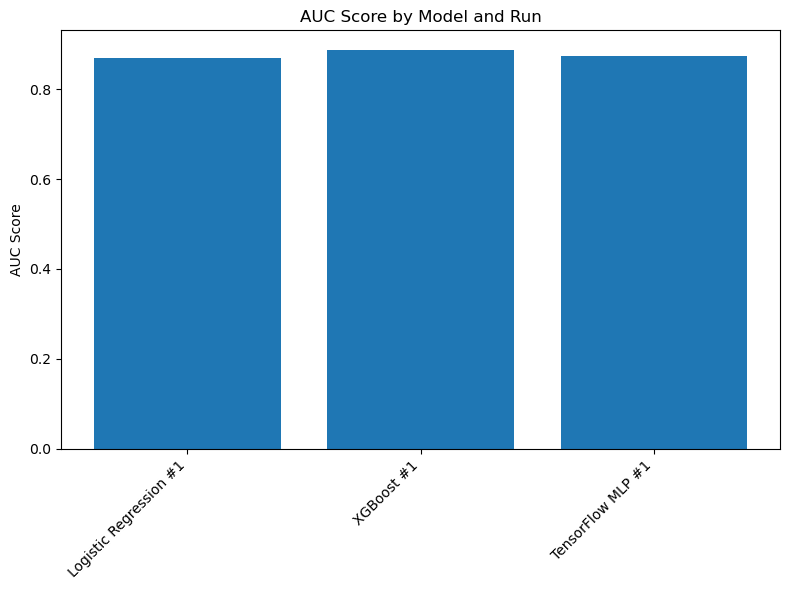

In [ ]:
plot_metric(results, metric='auc')
# Other metrics are in the output above. The names don't exactly map, though, because I'm difficult. 
#"model": name, "acc": acc, "auc": auc, "prec": prec, "rec": rec, "f1": f1, "f1_weighted": f1_w}

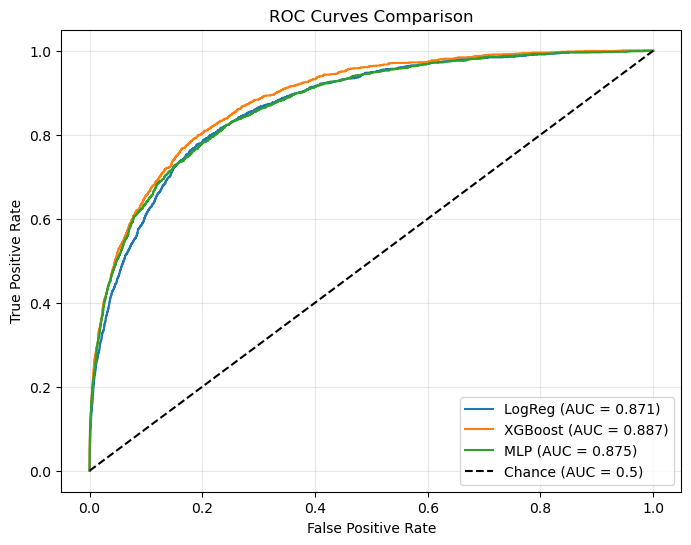

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr_lr,  tpr_lr,  _ = roc_curve(y_test, y_prob_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)

auc_lr  = auc(fpr_lr,  tpr_lr)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr,  tpr_lr,  label=f'LogReg (AUC = {auc_lr:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)


/var/folders/q4/5kbb7bd12kjf1rfmbkt6543r0000gn/T/ipykernel_4220/3561054755.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence = df_test.groupby(axis)['hospital_death'].mean().loc[counts.index]


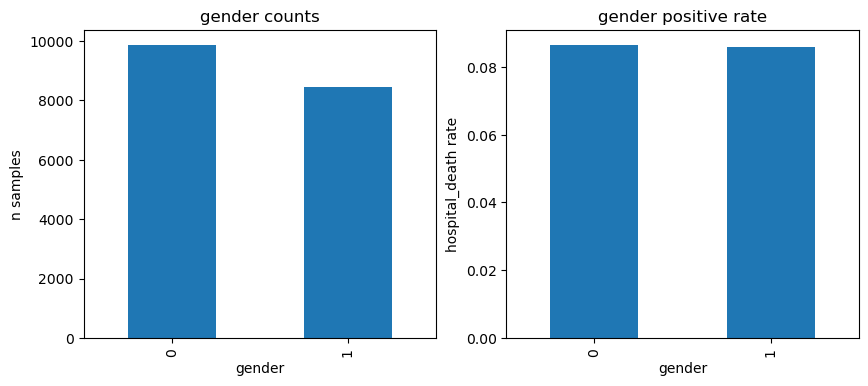

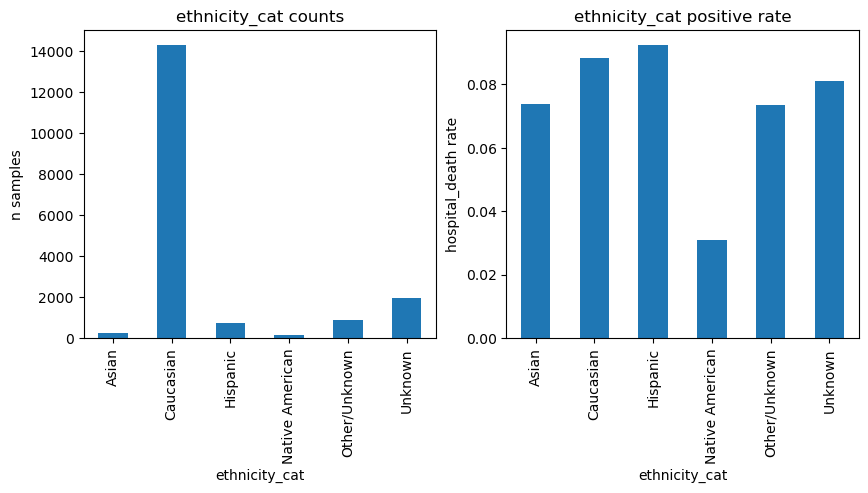

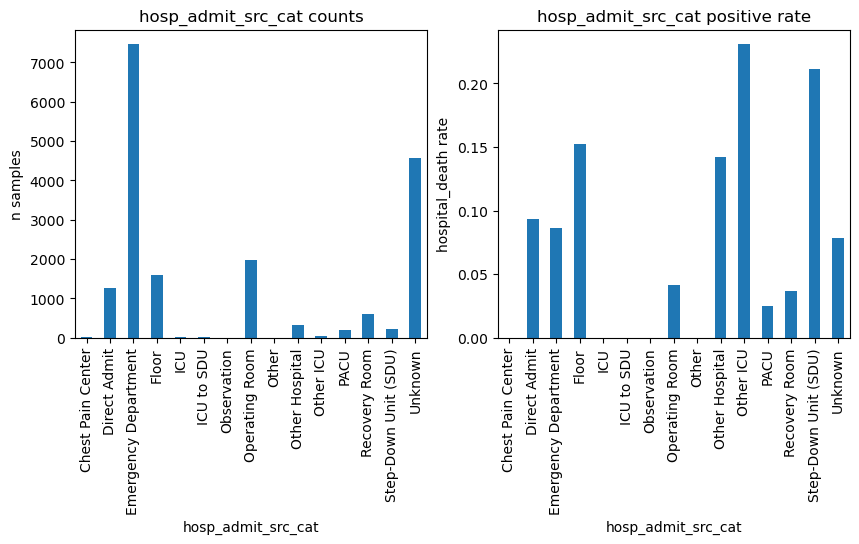

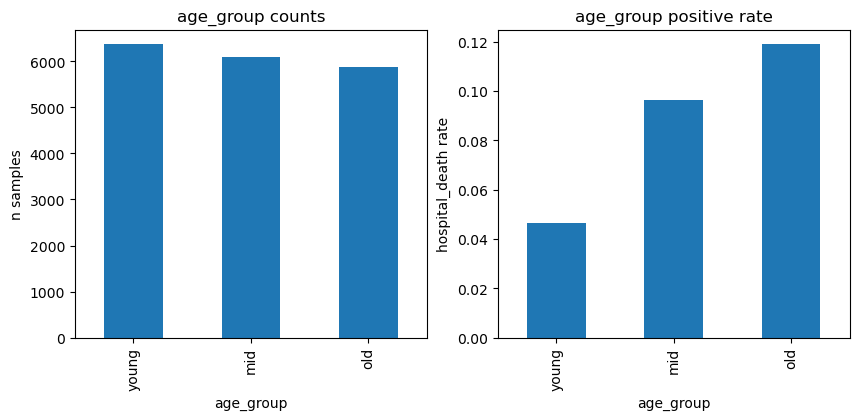

In [ ]:
eth_cols = ['ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown']

def decode_onehot(df, cols, prefix):
    def pick(row):
        ones = [c for c in cols if row[c] == 1]
        if len(ones) == 1:
            return ones[0].split(prefix,1)[1]
        else:
            return 'Unknown'
    return df.apply(pick, axis=1)

df_test = df_test.copy()
df_test['ethnicity_cat'] = decode_onehot(df_test, eth_cols, 'ethnicity_')

hosp_cols = [c for c in df_test.columns if c.startswith('hospital_admit_source_')]

df_test['hosp_admit_src_cat'] = decode_onehot(df_test, hosp_cols, 'hospital_admit_source_')

df_test['age_group'] = pd.qcut(df_test['age'], q=[0, 0.33, 0.66, 1.0], labels=['young','mid','old'])

demo_axes = {
    'gender' : df_test['gender'].unique(),
    'ethnicity_cat' : df_test['ethnicity_cat'].unique(),
    'hosp_admit_src_cat': df_test['hosp_admit_src_cat'].unique(),
    'age_group' : ['young','mid','old']}

models = [
    ('LogReg', y_pred_logreg,  y_prob_lr),
    ('XGBoost', y_pred_xgb, y_prob_xgb),
    ('MLP', y_pred_mlp, y_prob_mlp),]


for axis in ['gender','ethnicity_cat','hosp_admit_src_cat','age_group']:
    counts = df_test[axis].value_counts().sort_index()
    prevalence = df_test.groupby(axis)['hospital_death'].mean().loc[counts.index]
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
    counts.plot.bar(ax=ax1); ax1.set_title(f'{axis} counts'); ax1.set_xlabel(axis); ax1.set_ylabel('n samples')
    prevalence.plot.bar(ax=ax2); ax2.set_title(f'{axis} positive rate'); ax2.set_xlabel(axis); ax2.set_ylabel('hospital_death rate')

In [ ]:
records = []
for model_name, y_pred, y_prob in models:
    for axis, groups in demo_axes.items():
        for grp in groups:
            mask = df_test[axis] == grp
            if mask.sum() < 30:
                continue
            yt = y_test[mask]
            yp = y_pred[mask]
            yp_prob = y_prob[mask]

            records.append({
                'model' : model_name,
                'demographic': axis,
                'group': grp,
                'n_samples': int(mask.sum()),
                'accuracy': accuracy_score(yt, yp),
                'auc': roc_auc_score(yt, yp_prob) if yt.nunique()>1 else float('nan'),
                'precision': precision_score(yt, yp, zero_division=0),
                'recall': recall_score(yt, yp, zero_division=0),
                'f1': f1_score(yt, yp, zero_division=0)})

df_subgroup = pd.DataFrame(records)

table = df_subgroup.pivot_table(index=['demographic','group'], columns='model', values=['accuracy','auc','f1'], aggfunc='first')

print(table)

                                         accuracy                      \
model                                      LogReg       MLP   XGBoost   
demographic        group                                                
age_group          mid                   0.811024  0.864337  0.594652   
                   old                   0.701277  0.805617  0.468766   
                   young                 0.895637  0.929535  0.789077   
ethnicity_cat      Asian                 0.819672  0.885246  0.647541   
                   Caucasian             0.802931  0.866225  0.611863   
                   Hispanic              0.751020  0.855782  0.613605   
                   Native American       0.802469  0.907407  0.685185   
                   Other/Unknown         0.840934  0.896552  0.705228   
                   Unknown               0.824633  0.868728  0.651292   
gender             0                     0.807607  0.870524  0.635646   
                   1                     0.802530  

574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step


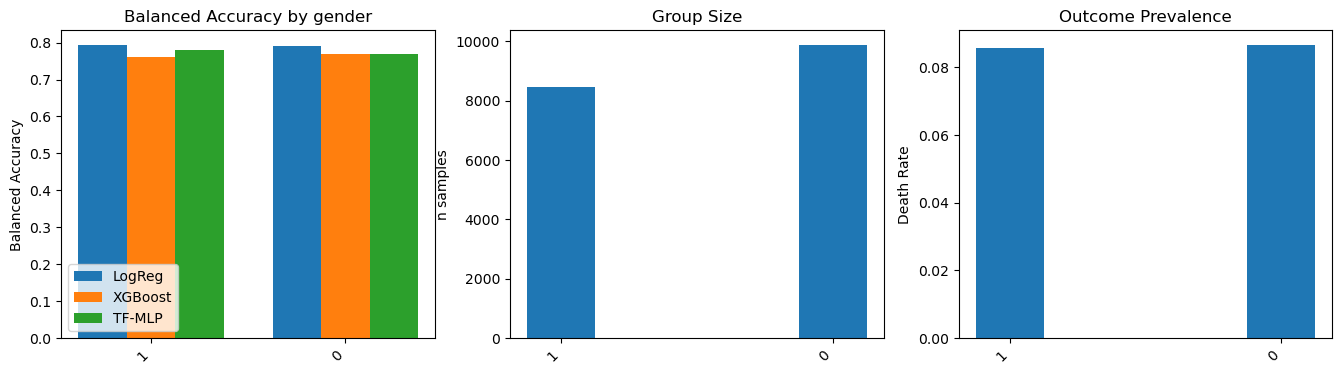

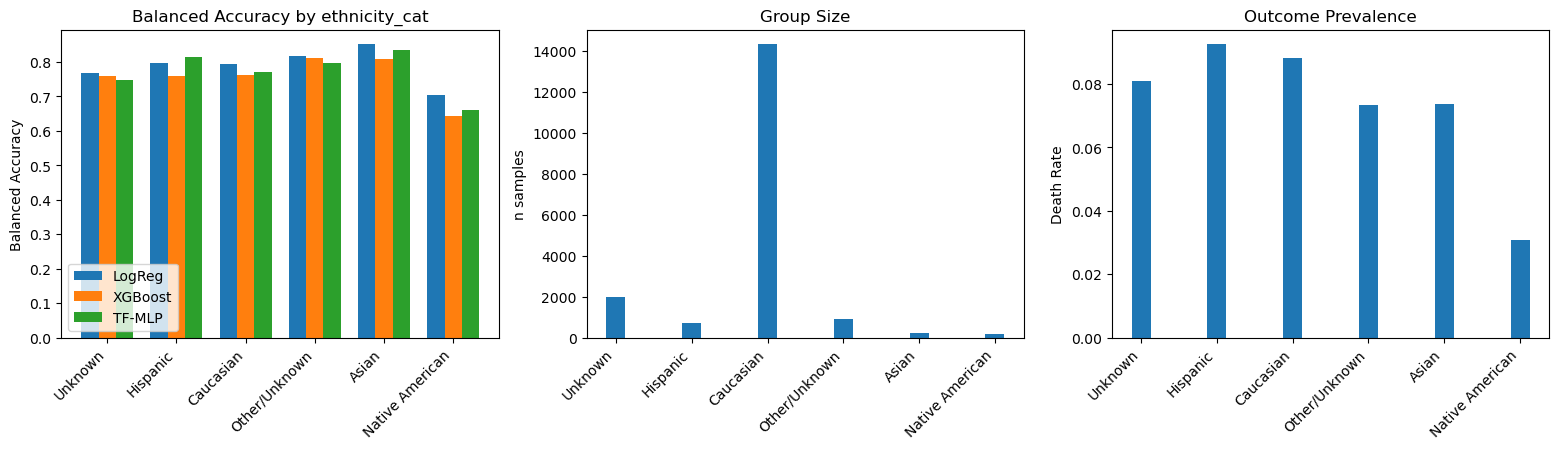

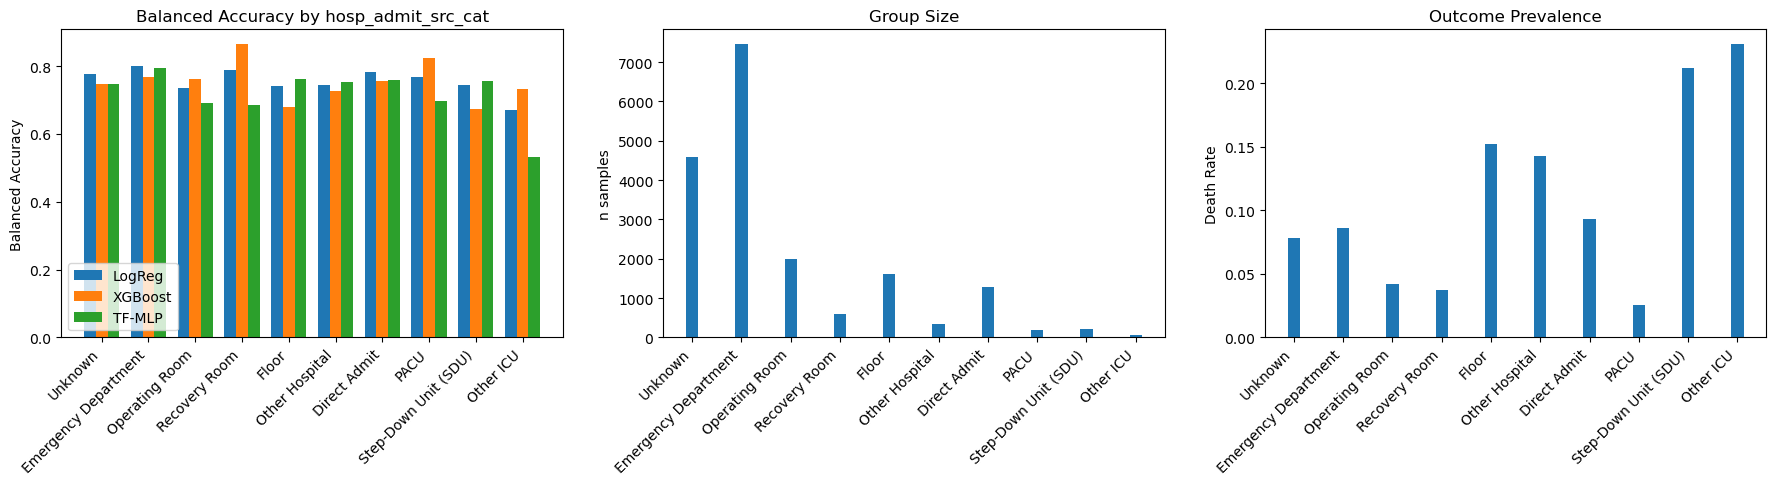

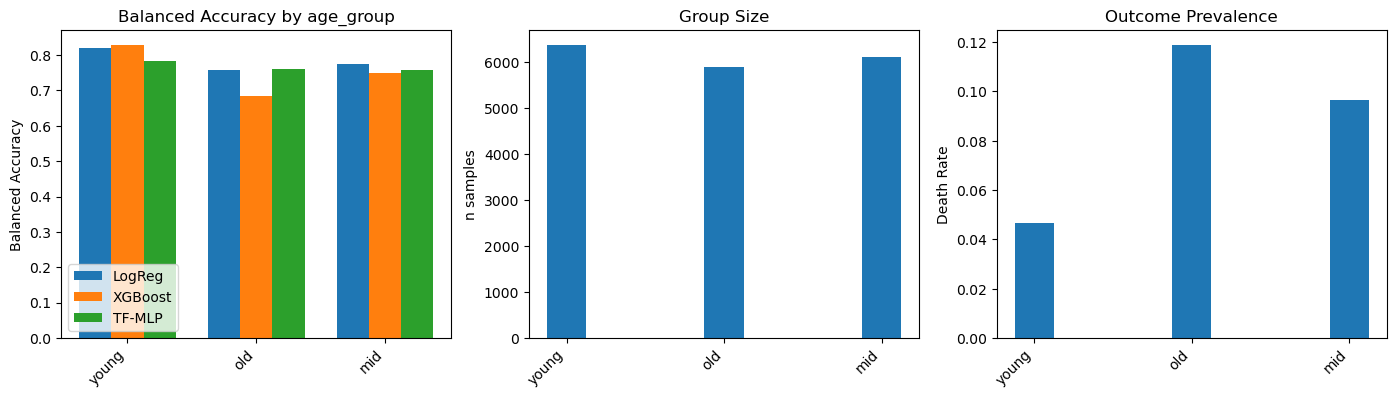

In [ ]:
y_prob_lr  = log_clf.predict_proba(X_test)[:,1]; y_pred_lr  = (y_prob_lr >= 0.5).astype(int)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:,1]; y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)
y_prob_mlp = mlp.predict(X_test).ravel();    y_pred_mlp = (y_prob_mlp >= 0.5).astype(int)

demographics = ['gender','ethnicity_cat','hosp_admit_src_cat','age_group']
models = [('LogReg',  y_pred_lr), ('XGBoost', y_pred_xgb), ('TF-MLP',  y_pred_mlp)]

records = []
for name, y_pred in models:
    for axis in demographics:
        for grp in df_test[axis].unique():
            mask = df_test[axis] == grp
            if mask.sum() < 30: 
                continue
            ba = balanced_accuracy_score(y_test[mask], y_pred[mask])
            records.append({'model': name, 'demographic': axis,'group': grp,
                'balanced_accuracy': ba, 'n_samples': mask.sum(), 'prevalence': df_test.loc[mask,'hospital_death'].mean()})
df_bal = pd.DataFrame(records)

for axis in demographics:
    df_axis = df_bal[df_bal['demographic']==axis]
    groups = list(df_axis['group'].unique())
    x = np.arange(len(groups))
    width = 0.25

    fig, (ax_ba, ax_count, ax_prev) = plt.subplots(1,3,figsize=(len(groups)*0.7+15,4))
    for i,(name,_) in enumerate(models):
        vals = []
        for grp in groups:
            sel = df_axis[(df_axis['model']==name)&(df_axis['group']==grp)]
            vals.append(sel['balanced_accuracy'].iloc[0] if not sel.empty else np.nan)
        ax_ba.bar(x + i*width, vals, width, label=name)
    ax_ba.set_xticks(x + width*(len(models)-1)/2)
    ax_ba.set_xticklabels([str(g) for g in groups], rotation=45, ha='right')
    ax_ba.set_title(f'Balanced Accuracy by {axis}')
    ax_ba.set_ylabel('Balanced Accuracy')
    ax_ba.legend(loc='lower left')

    counts = [ df_axis[df_axis['group']==grp]['n_samples'].iloc[0] for grp in groups ]
    ax_count.bar(x, counts, width)
    ax_count.set_xticks(x); ax_count.set_xticklabels([str(g) for g in groups], rotation=45, ha='right')
    ax_count.set_title('Group Size')
    ax_count.set_ylabel('n samples')

    prevs = [ df_axis[df_axis['group']==grp]['prevalence'].iloc[0] for grp in groups ]
    ax_prev.bar(x, prevs, width)
    ax_prev.set_xticks(x); ax_prev.set_xticklabels([str(g) for g in groups], rotation=45, ha='right')
    ax_prev.set_title('Outcome Prevalence')
    ax_prev.set_ylabel('Death Rate')